# Analyzing Ride Patterns and Weather Impact for Zuber's Chicago Launch
This project aims to analyze taxi ride data in Chicago, focusing on the impact of weather conditions on the duration of taxi rides from the Loop to O'Hare International Airport. The project involves parsing weather data, conducting exploratory data analysis, and testing a hypothesis regarding the effect of weather on ride durations. The dataset includes information on neighborhoods, cabs, trips, and weather records.

In [1]:
# Import necessary libraries
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
from scipy import stats
import requests
from bs4 import BeautifulSoup

In [2]:
# Load the CSV files into DataFrames
project_sql_result_01 = pd.read_csv('/datasets/project_sql_result_01.csv')
project_sql_result_04 = pd.read_csv('/datasets/project_sql_result_04.csv')
project_sql_result_07 = pd.read_csv('/datasets/project_sql_result_07.csv')

# Check for duplicates in each DataFrame
duplicates_01 = project_sql_result_01.duplicated().sum()
duplicates_04 = project_sql_result_04.duplicated().sum()
duplicates_07 = project_sql_result_07.duplicated().sum()

print(f"Duplicates in project_sql_result_01: {duplicates_01}")
print(f"Duplicates in project_sql_result_04: {duplicates_04}")
print(f"Duplicates in project_sql_result_07: {duplicates_07}")

# Remove duplicates if any
project_sql_result_01 = project_sql_result_01.drop_duplicates()
project_sql_result_04 = project_sql_result_04.drop_duplicates()
project_sql_result_07 = project_sql_result_07.drop_duplicates()

Duplicates in project_sql_result_01: 0
Duplicates in project_sql_result_04: 0
Duplicates in project_sql_result_07: 197


In [3]:
# Display the first few rows of each DataFrame to inspect the data
print("Project SQL Result 01:")
display(project_sql_result_01.head())

print("\nProject SQL Result 04:")
display(project_sql_result_04.head())

print("\nProject SQL Result 07:")
display(project_sql_result_07.head())

# Display basic information about each DataFrame
print("\nProject SQL Result 01 Info:")
display(project_sql_result_01.info())

print("\nProject SQL Result 04 Info:")
display(project_sql_result_04.info())

print("\nProject SQL Result 07 Info:")
display(project_sql_result_07.info())

Project SQL Result 01:


,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299



Project SQL Result 04:


,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000



Project SQL Result 07:


,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0



Project SQL Result 01 Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ KB


None


Project SQL Result 04 Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 2.2+ KB


None


Project SQL Result 07 Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 871 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            871 non-null    object 
 1   weather_conditions  871 non-null    object 
 2   duration_seconds    871 non-null    float64
dtypes: float64(1), object(2)
memory usage: 27.2+ KB


None

## Step 1: Parse the Data on Weather in Chicago in November 2017
First, we parse the weather data from the provided webpage. The weather data includes date, temperature, and a description of the weather conditions.

In [4]:
# URL of the webpage containing weather data
URL = 'https://practicum-content.s3.us-west-1.amazonaws.com/data-analyst-eng/moved_chicago_weather_2017.html'

# Send a request to the webpage
req = requests.get(URL)
soup = BeautifulSoup(req.text, 'lxml')

# Find the table containing the weather data
table = soup.find('table', attrs={"id": "weather_records"})

# Extract headings
heading_table = []
for row in table.find_all('th'):
    heading_table.append(row.text)

# Extract content
content = []
for row in table.find_all('tr'):
    if not row.find_all('th'):
        content.append([element.text for element in row.find_all('td')])

# Create DataFrame
weather_records = pd.DataFrame(content, columns=heading_table)

# Rename the columns
weather_records.columns = ['ts', 'temperature', 'description']

# Convert ts to datetime
weather_records['ts'] = pd.to_datetime(weather_records['ts'])

# Display the DataFrame
print("Weather Records DataFrame:")
display(weather_records)

Weather Records DataFrame:


,ts,temperature,description
0,2017-11-01 00:00:00,276.150,broken clouds
1,2017-11-01 01:00:00,275.700,scattered clouds
2,2017-11-01 02:00:00,275.610,overcast clouds
3,2017-11-01 03:00:00,275.350,broken clouds
4,2017-11-01 04:00:00,275.240,broken clouds
...,...,...,...
692,2017-11-29 20:00:00,281.340,few clouds
693,2017-11-29 21:00:00,281.690,sky is clear
694,2017-11-29 22:00:00,281.070,few clouds
695,2017-11-29 23:00:00,280.060,sky is clear


## Step 4. Exploratory data analysis (Python)
- Makes sure the data types are correct and convert them if necessary.
- Identifies the top 10 neighborhoods based on the average number of drop-offs.
- Generates the required graphs along with conclusions based on the visualizations.

In [5]:
# Ensure the data types are correct
project_sql_result_01['trips_amount'] = project_sql_result_01['trips_amount'].astype(int)
project_sql_result_04['average_trips'] = project_sql_result_04['average_trips'].astype(float)
project_sql_result_07['duration_seconds'] = project_sql_result_07['duration_seconds'].astype(float)
project_sql_result_07['weather_conditions'] = project_sql_result_07['weather_conditions'].astype(str)

# Verify the changes
print("Data Types After Conversion:")
display(project_sql_result_01.dtypes)
display(project_sql_result_04.dtypes)
display(project_sql_result_07.dtypes)

Data Types After Conversion:


company_name    object
trips_amount     int64
dtype: object

dropoff_location_name     object
average_trips            float64
dtype: object

start_ts               object
weather_conditions     object
duration_seconds      float64
dtype: object

### Identify the Top 10 Neighborhoods in Terms of Drop-offs

In [6]:
# Identify top 10 neighborhoods by average number of drop offs
top_10_neighborhoods = project_sql_result_04.nlargest(10, 'average_trips')

print("Top 10 Neighborhoods by Average Number of Drop-offs:")
display(top_10_neighborhoods)

Top 10 Neighborhoods by Average Number of Drop-offs:


,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


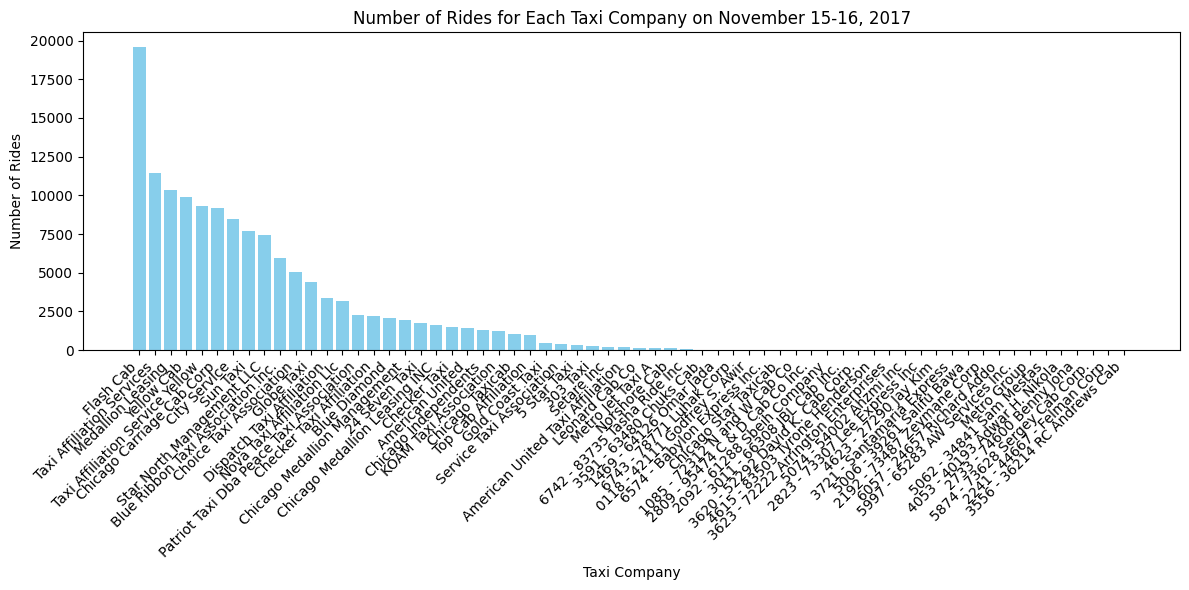

In [7]:
# Plot taxi companies and number of rides
plt.figure(figsize=(12, 6))
plt.bar(project_sql_result_01['company_name'], project_sql_result_01['trips_amount'], color='skyblue')
plt.xlabel('Taxi Company')
plt.ylabel('Number of Rides')
plt.title('Number of Rides for Each Taxi Company on November 15-16, 2017')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**From this graph, we can identify the most popular taxi companies based on the number of rides. Companies with higher numbers of rides might have a larger market share or better service coverage.**

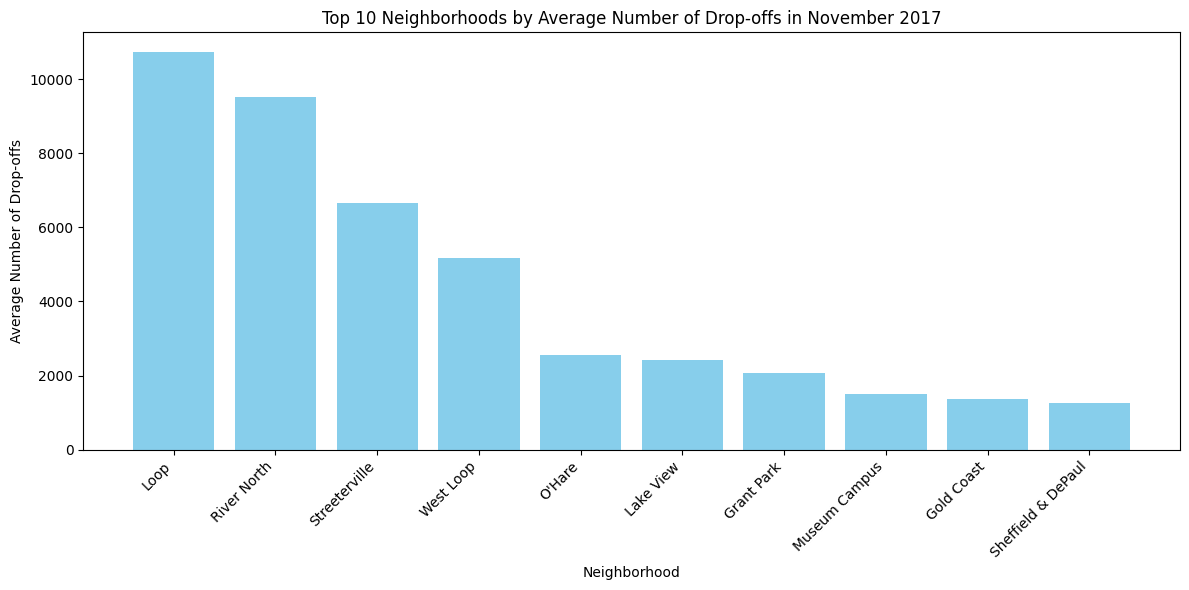

In [8]:
# Plot top 10 neighborhoods by number of drop-offs
plt.figure(figsize=(12, 6))
plt.bar(top_10_neighborhoods['dropoff_location_name'], top_10_neighborhoods['average_trips'], color='skyblue')
plt.xlabel('Neighborhood')
plt.ylabel('Average Number of Drop-offs')
plt.title('Top 10 Neighborhoods by Average Number of Drop-offs in November 2017')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Identifying these neighborhoods can help Zuber understand high-demand areas and optimize their service coverage. For example, the Loop and River North are among the top neighborhoods, indicating a high demand for taxi services in these areas.**

In [9]:
# Display the top 10 neighborhoods
display(top_10_neighborhoods)

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


## Step 5: Testing Hypotheses
Objective: test the hypothesis that the average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.
- Load the dataset: project_sql_result_07.csv
- Filter rides that occurred on Saturdays.
- Classify the rides based on weather conditions.
- Perform the t-test.

### Hypothesis Formation
- Null Hypothesis (H0): The average duration of rides from the Loop to O'Hare International Airport does not change on rainy Saturdays.
- Alternative Hypothesis (H1): The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.

### Criterion for Testing
We will use a **two-sample t-test** to compare the means of two independent groups (rainy Saturdays vs. non-rainy Saturdays) because:
- We have two independent samples.
- We want to compare their means.
- The t-test is appropriate for normally distributed interval data when the sample size is large.

### Setting Significance Level
We set the significance level **(𝛼) at 0.05**. This means we are willing to accept a 5% chance of rejecting the null hypothesis when it is actually true.

In [10]:
# Convert start_ts to datetime
project_sql_result_07['start_ts'] = pd.to_datetime(project_sql_result_07['start_ts'])

# Filter rides that occurred on saturdays
saturday_rides = project_sql_result_07[project_sql_result_07['start_ts'].dt.dayofweek == 5]

# Separate rides based on weather conditions
rainy_saturdays = saturday_rides[saturday_rides['weather_conditions'] == 'Bad']['duration_seconds']
non_rainy_saturdays = saturday_rides[saturday_rides['weather_conditions'] == 'Good']['duration_seconds']

# Perform a t-test to compare the durations
t_stat, p_value = stats.ttest_ind(rainy_saturdays, non_rainy_saturdays)

# Set the significance level
alpha = 0.05

# Conclusion
if p_value < alpha:
    conclusion = "Reject the null hypothesis. The average duration of rides changes on rainy Saturdays."
else:
    conclusion = "Fail to reject the null hypothesis. The average duration of rides does not change on rainy Saturdays."

print("t-statistic:", t_stat)
print("p-value:", p_value)
print("Conclusion:", conclusion)

t-statistic: 5.427957689754561
p-value: 7.397770692813658e-08
Conclusion: Reject the null hypothesis. The average duration of rides changes on rainy Saturdays.


## Overall Conclusion
**The project provided valuable insights into taxi ride patterns and external factors affecting ride durations in Chicago. Key findings include:**

- Market Dominance: Flash Cab and Taxi Affiliation Services are the leading taxi companies, significantly outpacing other companies in terms of ride numbers.
- High-Demand Areas: The Loop and River North are the top neighborhoods for taxi drop-offs, indicating high passenger activity in these areas.
- Impact of Weather: Rainy weather conditions significantly increase the duration of taxi rides from the Loop to O'Hare International Airport on Saturdays.

**Recommendations for Zuber**<br>
- Operational Adjustments: Increase the number of available vehicles on rainy Saturdays to meet higher demand and reduce wait times.
- Train drivers on best practices for driving in rainy conditions to ensure safety and efficiency.

**Service Optimization:** <br>
- Focus on high-demand areas like the Loop and River North to optimize service coverage and enhance customer satisfaction.
- Implement surge pricing or additional incentives for drivers during peak hours and bad weather conditions to maintain service levels.

**Customer Communication:**<br>
- Use the Zuber app to notify passengers of potential delays on rainy Saturdays and provide accurate ride duration estimates.
- Offer alternative routes or travel suggestions during inclement weather to improve the passenger experience.

**By leveraging these insights and recommendations, Zuber can enhance its service quality, meet customer expectations, and establish a strong presence in the competitive Chicago ride-sharing market.**